In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import copy
from IPython.display import clear_output
#from plot_util import plot_value_grid
%matplotlib inline

In [2]:
# Task 1: build maze

In [3]:
WIDTH = 10
START = (0, 0)
GOAL = (9, 9) #lower left corner

In [4]:
# Task 1 Build maze
A = [
    (-1, 0), #up
    (0, 1), #right
    (0, -1), #left
    (1, 0), #down
    (0,0), #stay
]
S=np.zeros((10,10), dtype="int")
dA = len(A)
dS = len(S)

In [5]:
for i in range(4): # set walls to 1
    S[3][i]=1
    S[1][i+6]=1
    S[i+5][6]=1
START = (0,0)
GOAL = (dS-1, dS-1)
S[GOAL] = 3

In [6]:
S

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])

In [7]:
def validState(s):
    if (s[0] < 0 or s[1]<0): #out of boundary
        return False
    if (s[0] > 9 or s[1] > 9):
        return False
    if (S[s] == 1): # wall check
        return False
    return True

In [8]:
def plot_value_grid(pi, V, msg=""):
    V = np.reshape(V, (dS, dS))
    fig = plt.figure(figsize=(3, 4), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
   
    quiver_action_dict = [(0, 1), (1, 0), (-1, 0), (0, -1), (0, 0)]
    
    for k, _ in np.ndenumerate(pi):
        if(S[k[0], k[1]] == 0): # don't draw arrows on the walls
            a = np.argmax(pi[k[0],k[1],:].flatten())
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][0], quiver_action_dict[a][1], color='r')

In [9]:
def BuildMaze():
    Ps_sa = np.zeros((dS, dS, dA, dS, dS, 1))
    Rs_sa = -np.ones((dS, dS, dA, dS, dS, 1))
    all_state=list(itertools.product(range(dS), range(dS)))
    
    for state in all_state:
        if (state == GOAL):
            Ps_sa[state[0], state[1], :, state[0], state[1], :] = 1.0 # all actions result in moving to goal from goal
            Rs_sa[state[0], state[1], :, :, :, :] = 0.0
        
        elif (validState(state) == True):
            for i in range(len(A)):
                s_next=(state[0]+A[i][0], state[1]+A[i][1])
                if (validState(s_next)==False): # next state is the wall or out of bounds
                    Rs_sa[state[0],state[1], i, :, :, :] = -10000.0
                    s_next=state # cannot move to next state
                Ps_sa[state[0], state[1], i, s_next[0], s_next[1], :]=1.0 # move back to og state or a new state
                       
        elif (validState(state) == False):
            Ps_sa[state[0], state[1], :, state[0], state[1], :] = 0.0
            
    return Ps_sa, Rs_sa

In [10]:
'''The policy is stationary, which means π[a′ | s′] is permute_dimensions(π[a | s], dim1->dim4, dim2->dim5, dim3->dim6)
Use broadcasting '.*', e.g.,
p(s′ a′ | s, a) = π[a′|s′] .* p(s′ | s, a)
sum_s′p(s′ | s, π[a|s]) .* V[s′], where V[s′] is the value of the next state with dimensions 1 x 1 x 1 x dS x dS x 1.
The value of the current state has dimensions dS x dS x 1 x 1 x 1 x 1. 
"V of the next state" is permute_dimensions("V of the current state", dims1->dims4, dims2->dims5)'''
def policy_evaluation(POLICY, Ps, Rs, discount, iteration):
    theta=1e-6
    V = np.zeros((dS, dS, 1, 1, 1, 1))
    V_copy = np.zeros((1, 1, 1, dS, dS, 1))
    
    reward = np.sum(POLICY*np.sum(Ps*Rs, axis=(3,4), keepdims=True), axis=2, keepdims=True)
    
    for i in range(iteration):
        diff = 0
        V_copy = np.transpose(V, axes=(3,4,5,0,1,2))
        V = reward + discount*np.sum(POLICY*np.sum(Ps*V_copy, axis=(3,4), keepdims=True), axis=2, keepdims=True)
    
        V_copy = np.transpose(V_copy, axes=(3,4,5,0,1,2))
        diff = max(diff, np.max(abs(V-V_copy)))
    
        if (diff<theta):
            break
    return V, diff

In [11]:
# Task 4
'''Implement the Policy Improvement (PI) Algorithm, and find the optimal policy π*.
Visualize the optimal value function, V_i, on a 2D plot at 3 different iterations, i, of PI.
Explain your observations.'''

def policy_improvement(POLICY, Ps, Rs, V, discount):
    pi = np.zeros((dS, dS, dA, 1, 1, 1)) # policy to be improved and returned
    pi_v = np.zeros((dS, dS, dA, 1, 1, 1)) # value table of the policy
    
    pi_converged = False
    
    reward = np.sum(Ps*Rs, axis=(3,4), keepdims=True)
    
    pi_v = reward + discount*np.sum(Ps * np.transpose(V, axes=(3,4,5,0,1,2)), axis=(3,4), keepdims=True)
    
    argmax_policy = np.argmax(pi_v, axis=2)
    
    for i in range(dS):
        for j in range(dS):
            a = argmax_policy[i,j]
            pi[i,j,a] = 1
    
    if (np.allclose(POLICY, pi) == True): 
        pi_converged = True
    
    return pi, pi_converged

In [12]:
# Task 4
def policy_iteration(POL, Ps, Rs, discount, plot):
    num=0
    
    while True:
        V, delta = policy_evaluation(POL, Ps, Rs, discount, 100) 
        POL, policy_stable = policy_improvement(POL, Ps, Rs, V, discount)

        if plot and num + 1 in plot or delta == 0:
            plot_value_grid(POL, V,  msg='Iteration {}'.format(num + 1))
        
        if delta <= 0 or num == 99 or policy_stable:  
            break
        
        num+=1
        
    return POL, V

In [13]:
Ps_sa, Rs_sa = BuildMaze() # Ps_sa and Rs_sa is constant

/Users/dazhouliu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/dazhouliu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/quiver.py:651: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


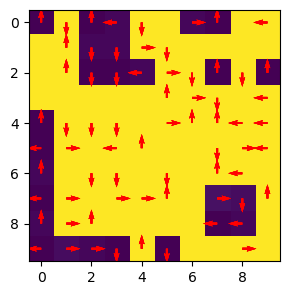

In [14]:
# random policy
pi_random = np.zeros((dS, dS, dA, 1, 1, 1))
for i in range(dS):
    for j in range(dS):
        a = random.randint(0, 4)
        pi_random[i,j,a,:,:,:] = 1

# Test policy evaluation
V, delta = policy_evaluation(pi_random, Ps_sa, Rs_sa, 0.99, 100) 
plot_value_grid(pi_random, V)

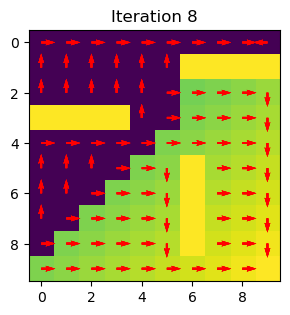

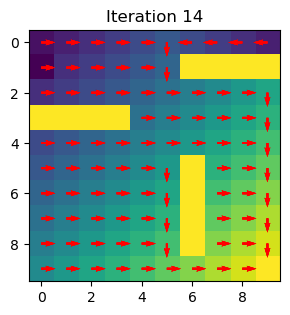

In [15]:
#i_random = np.zeros((dS, dS, dA, 1, 1, 1)) # initial policy
#pi_random[:,:,3] = 1 # set one of the actions to 1
pol_opt, V_opt,  = policy_iteration(pi_random, Ps_sa, Rs_sa, 0.98, plot=[8, 20]) # let the function directly use the above policy

In [16]:
'''Write a function, s′, r = step(s, a), that receives the current state, s, and the current action, a, and
returns the next state, s′, and reward, r.
Generate 10 trajectories from 10 different initial states, using a random policy.
Generate 10 trajectories from 10 different initial states, using the optimal policy from Task 4 above.
Explain your observations.'''
def step(s, a): # immidiate reward

    if (s == GOAL):
        reward=0
        s_next=s

    elif (validState(s) == True):
        s_next = (s[0] + A[a][0], s[1] + A[a][1])
        if (validState(s_next) == False):
            reward = -100 # hit the wall or out of bounds
            s_next=s
        else:
            s = s_next
            reward = -1
    
    elif (validState(s) == False):
        s_next=s
        reward=-1
    
    return s_next, reward

In [17]:
def generate_traj(init_state, pi, ctr):
    traj = []
    reward = []
    state = init_state
    for i in range(ctr):
        if (state == GOAL):
            break
        #a = (np.argmax(pi, axis=2).squeeze()[state[0]][state[1]])
        #a = np.argmax(pi[state[0], state[1], :].flatten())
        a = np.argmax(pi[state[0], state[1], :].flatten())
        state_next, r = step(state, a)
        state = state_next
        traj.append(state_next)
        reward.append(r)

    return traj, reward

In [18]:
pi_random = np.zeros((dS, dS, dA, 1, 1, 1))
for i in range(dS):
    for j in range(dS):
        a = random.randint(0, 4)
        pi_random[i,j,a,:,:,:] = 1

In [19]:
print("Random policy")
for i in range(10):
    states = list(itertools.product(range(dS), range(dS)))
    valid_state = filter(validState, states)
    init_state = random.choice(list(valid_state))
    t_buffer, r_buffer = generate_traj(init_state, pi_random, 500)
    
    print("Iter", i, sum(r_buffer))

Random policy
Iter 0 -500
Iter 1 -500
Iter 2 -500
Iter 3 -49901
Iter 4 -500
Iter 5 -500
Iter 6 -500
Iter 7 -500
Iter 8 -500
Iter 9 -500


In [20]:
print("Optimal policy")
for i in range(10): # Use the optimal policy after policy iteration
    states = list(itertools.product(range(dS), range(dS)))
    valid_state = filter(validState, states)
    init_state = random.choice(list(valid_state))
    t_buffer, r_buffer = generate_traj(init_state, pol_opt, 500)
    
    print("Iter", i, sum(r_buffer))

Optimal policy
Iter 0 -16
Iter 1 -8
Iter 2 -12
Iter 3 -3
Iter 4 -16
Iter 5 -9
Iter 6 -5
Iter 7 -8
Iter 8 -10
Iter 9 -8


Observations: When using optimal policy, the cumulative rewards of each of the trajectory approaches to zero. When using random policy, the cumulative rewards of each trajectory is much lower than the optimal policy.

In [21]:
def plot_policy_from_qtable(Q_t, msg=""):
    #plt.ion()
    
    plt.figure(figsize=(3, 4), tight_layout=True)
    plt.title(msg)
    policy = np.argmax(Q_t, axis=2)
    ax = plt.gca()

    plt.imshow(np.max(Q_t, axis=2).reshape(dS,dS))
    quiver_action_dict = [(0, 1), (1, 0), (-1, 0), (0, -1), (0, 0)]
    for k, v in np.ndenumerate(policy):
        if(S[k] == 0):
            plt.quiver(k[1], k[0] , quiver_action_dict[v][0], quiver_action_dict[v][1], color='r')
    plt.show()

###Model Free - Q learning and SARSA###

In [22]:
def choose_action_epsilon(Q_table, s, epsilon):
    ran = random.uniform(0, 1) # draw from uniform distribution
    if (ran < epsilon): # off policy
        return random.randint(0, 4)
    else:
        return np.argmax(Q_table[s[0], s[1], :])

In [23]:
"""Implement Q-learning algorithm for the tabular case, where Q function is given by a table."""
def Q_learning(discount, episodes, max_steps=500, show=True):
    Q = np.zeros((dS, dS, dA)) # this is the Q function/table
    
    r_buffer=[]
    r_sum = 0
    Qs = []
    sum_steps=0
    for episode in range(episodes):
        if episode < 500:
            states = list(itertools.product(range(dS), range(dS)))
            valid_state = filter(validState, states)
            s = random.choice(list(valid_state))
        else:
            s=START
        i=0
        r_sum = 0
        while (s != GOAL or i < max_steps):
            a = choose_action_epsilon(Q, s, epsilon)
            s_next, r = step(s, a)
            Q_max = np.max(Q[s_next[0], s_next[1], :])
            Q[s[0]][s[1]][a] = Q[s[0]][s[1]][a] + lr*(r + discount*Q_max - Q[s[0]][s[1]][a]) # temporal difference
            s = s_next
            r_sum += r
            i += 1
        
        sum_steps = sum_steps + i
        r_buffer.append(r_sum)
        if show:
            if (episode+1) % 20 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))
    
    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))

            
    return r_buffer

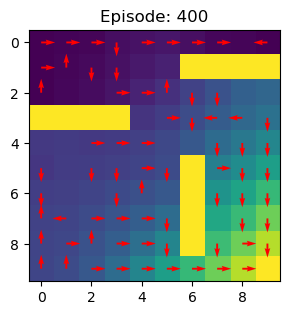

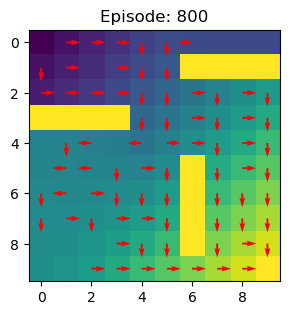

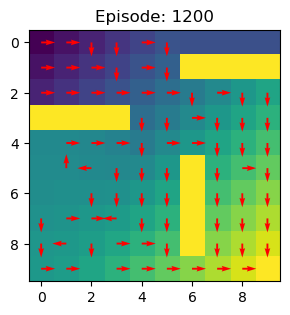

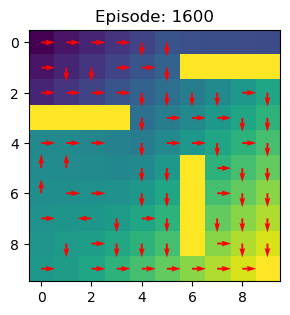

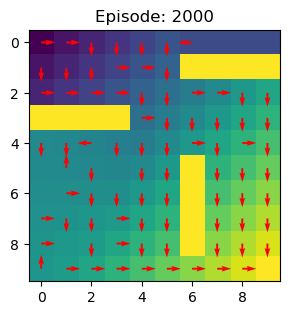

In [24]:
lr = 0.1
epsilon = 0.2
r_buffer = Q_learning(0.99, 2000)

In [25]:
'''Plot an accumulated reward as a function of the iteration number of Q-learning algorithm 
for 5 runs of Q-learning from scratch. Plot an average curve of the 4 runs of Q-learning, 
and the variance (use fill_between). Explain your observations'''
r_list = []
lr = 0.1
epsilon = 0.2
for i in range(5):
    r_traj = Q_learning(0.99, 2000, show=False)
    r_list.append(r_traj)

r_list = np.array(r_list)
r_list = np.average(r_list, axis=0)
var = np.std(r_list)

hi = r_list + 0.5*var
lo = r_list - 0.5*var

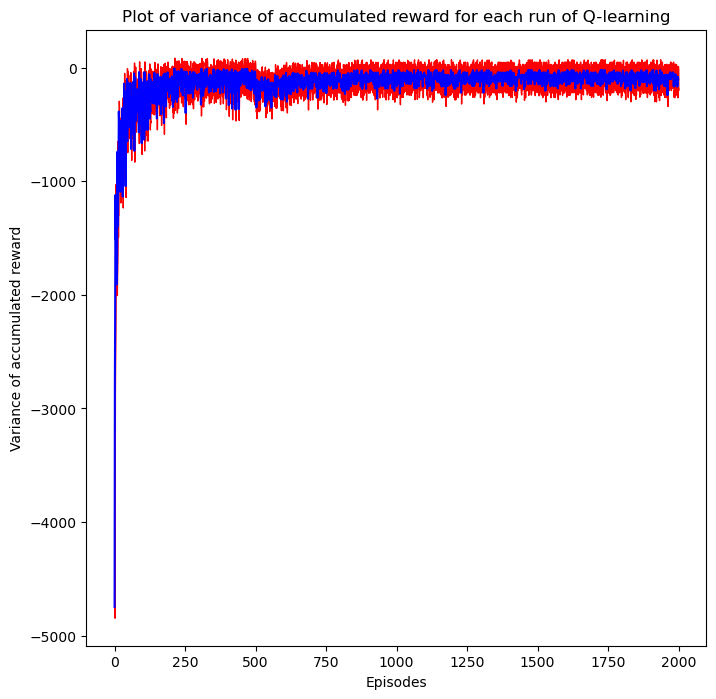

In [26]:
plt.figure(figsize=(8, 8))
plt.fill_between(range(len(hi)), hi, lo, color='red')
plt.plot(r_list, color="blue")
plt.title("Plot of variance of accumulated reward for each run of Q-learning")
plt.xlabel("Episodes")
plt.ylabel("Variance of accumulated reward")

plt.show()

Observations: the cumulative reward improves significantly within 200 episodes for each of the 5 runs. The upward trend of the reward curve indicates the agent is learning by Q-learning. After 250 episodes, the accumulated reward variated around zero and -500. The variance shows that off-policy exploration may incur penalties, despite the optimal policy the agent may derive.

In [35]:
'''Task 7: Repeat Task 5 with the SARSA Algorithm.'''
def SARSA(discount, episodes, max_steps=500, show=True):
    Q = np.zeros((dS, dS, dA))
    
    r_buffer=[]
    r_sum = 0
    Qs = []
    sum_steps=0
    for episode in range(episodes):
        if episode<500: 
            s = (np.random.randint(0, dS), np.random.randint(0, dS))
            while S[s] != 0:
                s = (np.random.randint(0, dS), np.random.randint(0, dS))
        else:
            s=START
        i=0
        r_sum=0
        a = choose_action_epsilon(Q, s, epsilon)
        while (s != GOAL or i < max_steps):
            a = choose_action_epsilon(Q, s, epsilon)
            s_next, r = step(s, a)
            Q_max = np.max(Q[s_next[0], s_next[1], :])
            Q[s[0]][s[1]][a] = Q[s[0]][s[1]][a] + lr*(r + discount*Q_max - Q[s[0]][s[1]][a]) # temporal difference
            s = s_next
            r_sum += r
            i += 1
        
        sum_steps = sum_steps + i
        r_buffer.append(r_sum)
        if show:
            if (episode+1) % 20 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))
    
    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))

            
    return r_buffer

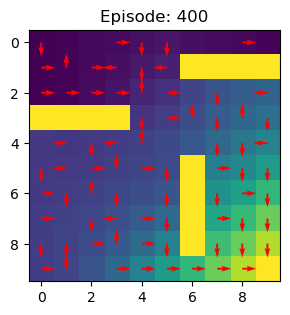

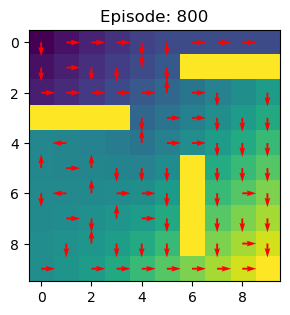

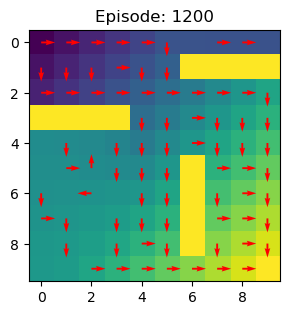

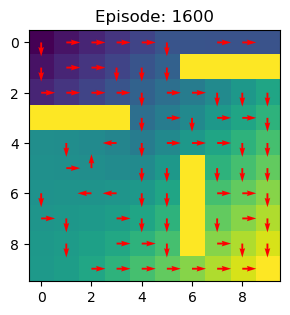

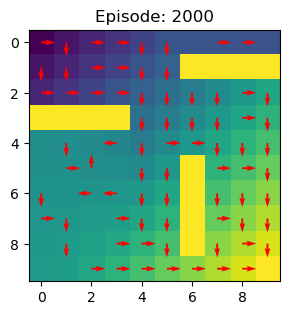

In [36]:
lr = 0.1
epsilon = 0
r_buffer = Q_learning(0.99, 2000)

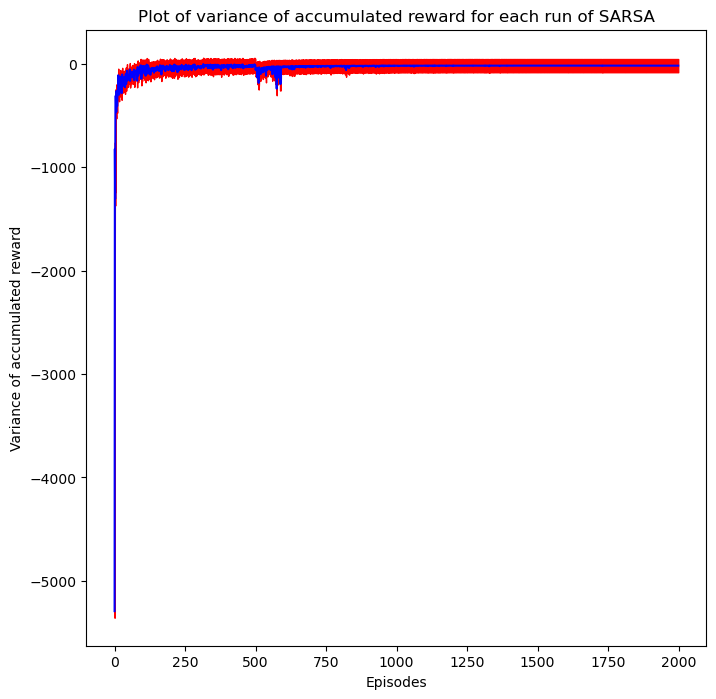

In [37]:
'''Plot an accumulated reward as a function of the iteration number of Q-learning algorithm 
for 5 runs of Q-learning from scratch. Plot an average curve of the 4 runs of Q-learning, 
and the variance (use fill_between). Explain your observations'''
lr = 0.1
epsilon = 0
r_list = []
for i in range(5):
    r_traj = SARSA(0.99, 2000, show=False)
    r_list.append(r_traj)

r_list = np.array(r_list)
r_list = np.average(r_list, axis=0)
var = np.std(r_list)

hi = r_list + 0.5*var
lo = r_list - 0.5*var

plt.figure(figsize=(8, 8))
plt.fill_between(range(len(hi)), hi, lo, color='red')
plt.plot(r_list, color="blue")
plt.title("Plot of variance of accumulated reward for each run of SARSA")
plt.xlabel("Episodes")
plt.ylabel("Variance of accumulated reward")

plt.show()

Observations: the cumulative reward improves significantly within 200 episodes for each of the 5 runs. After 250 episodes, the accumulated reward sighly fluctuated around zero and -500. The variance is much smaller, indicating that SARSA is greedy and always chooses the current optimal policy for a safer path.